## 1. Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 65.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

## 2. Read dataset

In [110]:
file_path = '/content/drive/MyDrive/Computer Vision/vqa/data.csv'
data = pd.read_csv(file_path)

class_counts = data['answer'].value_counts()
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['Class', 'Count']
print(class_counts_df)

                           Class  Count
0                              2    554
1                          table    421
2                          chair    367
3                              3    327
4                         window    277
...                          ...    ...
1438           brown, red, black      1
1439                 pipe, light      1
1440                        4, 6      1
1441    white, blue, black, gray      1
1442  blue, purple, black, white      1

[1443 rows x 2 columns]


In [112]:
# Menghitung jumlah data pada masing-masing class berdasarkan 'answer'
class_counts = data['answer'].value_counts()

# Identifikasi kelas yang jumlah datanya lebih dari 300
classes_to_reduce = class_counts[class_counts > 300].index

# Function untuk melakukan undersampling
def undersample_class(df, class_name, max_count):
    class_df = df[df['answer'] == class_name]
    if len(class_df) > max_count:
        class_df = class_df.sample(max_count, random_state=42)  # Random state untuk reproduktifitas
    return class_df

# Membuat dataframe baru dengan jumlah data yang seimbang
balanced_data = pd.concat([undersample_class(data, cls, 300) if cls in classes_to_reduce else data[data['answer'] == cls] for cls in data['answer'].unique()])

# Menampilkan jumlah data pada masing-masing kelas setelah undersampling
print(balanced_data['answer'].value_counts())

answer
2                             300
3                             300
chair                         300
table                         300
window                        277
                             ... 
brown, red, black               1
pipe, light                     1
4, 6                            1
white, blue, black, gray        1
blue, purple, black, white      1
Name: count, Length: 1443, dtype: int64


In [114]:
formatted_data = []

for index, row in balanced_data.iterrows():
    image_id = row['image_id']
    question = row['question']
    answer = row['answer']

    image_path = f'{image_id}.png'

    formatted_data.append({
        'image_path': image_path,
        'question': question,
        'answer': answer
    })

formatted_df = pd.DataFrame(formatted_data)

train_df, temp_df = train_test_split(formatted_df, test_size=0.2, random_state=42)

test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 9599
Testing set size: 1200
Validation set size: 1200


In [115]:
train_data = []

for index, row in train_df.iterrows():
    image_path = row['image_path']
    question = row['question']
    answer = row['answer']

    train_data.append({
        'image_path': image_path,
        'question': question,
        'answer': answer
    })

In [116]:
val_data = []

for index, row in val_df.iterrows():
    image_path = row['image_path']
    question = row['question']
    answer = row['answer']

    val_data.append({
        'image_path': image_path,
        'question': question,
        'answer': answer
    })

In [117]:
test_data = []

for index, row in test_df.iterrows():
    image_path = row['image_path']
    question = row['question']
    answer = row['answer']

    test_data.append({
        'image_path': image_path,
        'question': question,
        'answer': answer
    })

## 3. Data Preprocessing

In [118]:
eng = spacy.load("en_core_web_sm") # Load the English model to tokenize English text

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]


vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [119]:
len(vocab)

644

In [120]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [121]:
example_question = "How man chairs are there?"
max_seq_len = 20

tokenize(example_question, max_seq_len)

[3, 211, 32, 9, 22, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [122]:
all_data = train_data + val_data + test_data

classes = set([sample['answer'] for sample in all_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx_to_classes)

{0: 'clothes, papers, cup, salt_and_pepper', 1: 'vase, banana', 2: 'tape', 3: 'clothes, paper', 4: 'soap, bottle_of_liquid, hand_sanitizer, toothpaste, face_wash_cream', 5: 'shelf_frame, picture, wall_decoration', 6: 'book, box, glass', 7: 'air_conditioner', 8: 'fan, light', 9: 'toy_triangle', 10: 'basket, hair_dryer', 11: 'glass_ware', 12: 'certificate', 13: 'coffee_machine, juicer', 14: 'treadmill', 15: 'indoor_fountain', 16: 'coffee_packet, cup', 17: 'hanging_hooks', 18: 'excercise_ball', 19: 'laptop, printer', 20: 'bed, books', 21: 'remote_control, radio', 22: 'pineapple, banana', 23: 'microwave', 24: 'container, bag', 25: 'sponge, bottle_of_liquid', 26: 'magnet', 27: 'package_of_bedroom_sheets, pillow', 28: 'lamp, papers, bottle', 29: 'monitor, keyboard, mouse, computer, paper', 30: 'table, box', 31: 'microwave, bottle, fruit, paper', 32: 'blue, yellow', 33: 'display_board', 34: 'keyboard, mouse, mouse_pad', 35: 'jug', 36: 'paper, console_controller, remote_control', 37: 'drawer_k

## 4. Create Pytorch dataset

In [123]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        max_seq_len=20,
        transform=None,
        root_dir='/content/drive/MyDrive/Computer Vision/vqa/images'
    ):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[index]['answer']
        label = classes_to_idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [124]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [125]:
train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)
val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)
test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)

In [126]:
train_batch_size = 128
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## 5. Create Model

In [127]:
class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name='resnet50',
        embeddding_dim=300,
        n_layers=1,
        hidden_size=128,
        dropout_prob=0.2
    ):
        super(VQAModel, self).__init__()
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm1 = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.lstm2 = nn.LSTM(
            input_size=hidden_size*3,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, n_classes)

    def forward(self, img, text):
        img_features = self.image_encoder(img)

        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm1(text_emb)

        lstm_out = lstm_out[:, -1, :]

        combined = torch.cat((img_features, lstm_out), dim=1)
        x, _ = self.lstm2(combined)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [128]:
n_classes = len(classes)
img_model_name = 'resnet50'
hidden_size = 128
n_layers = 1
embeddding_dim = 64
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    dropout_prob=dropout_prob
).to(device)

In [129]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([128, 1443])


## 6. Training

In [130]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [131]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [134]:
lr = 1e-2
epochs = 5

scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [135]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


EPOCH 1:	Train loss: 5.7098	Val loss: 5.3725	Val Acc: 0.05416666666666667
EPOCH 2:	Train loss: 5.2477	Val loss: 9.1846	Val Acc: 0.0016666666666666668
EPOCH 3:	Train loss: 5.0840	Val loss: 5.2330	Val Acc: 0.06833333333333333
EPOCH 4:	Train loss: 4.8860	Val loss: 5.1654	Val Acc: 0.08666666666666667
EPOCH 5:	Train loss: 4.8329	Val loss: 5.1429	Val Acc: 0.09166666666666666


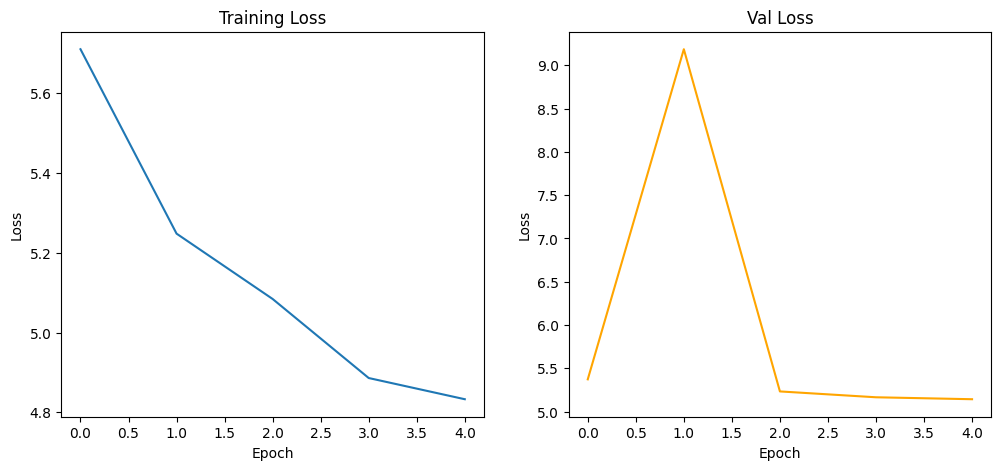

In [136]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 7. Evaluation

In [137]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.09166666666666666
Test accuracy:  0.08083333333333333


## Predict

In [138]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:00


In [139]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from torchvision import transforms
from PIL import Image
import torch
import spacy

# Load your Spacy model for tokenization
eng = spacy.load("en_core_web_sm")

# Assume 'model', 'vocab', 'idx_to_classes' are already defined and loaded
# Make sure to move your model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def preprocess_image(image_bytes, transform):
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    return image

def preprocess_question(question, vocab, max_seq_len=20):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = []
    for token in tokens:
        # Attempt to get the index of the token from vocab
        # Fallback to a predefined index for unknown tokens if the token is not found
        token_index = vocab[token] if token in vocab else vocab['<unk>']
        sequence.append(token_index)
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]
    question_tensor = torch.tensor(sequence).unsqueeze(0)  # Add batch dimension
    question_tensor = question_tensor.to(device)
    return question_tensor

def predict_answer(model, image_bytes, question, transform, vocab, idx_to_classes, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image = preprocess_image(image_bytes, transform)
        question_tensor = preprocess_question(question, vocab)

        output = model(image, question_tensor)
        prediction = output.argmax(dim=1).item()

        answer = idx_to_classes[prediction]
        return answer

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Widgets setup
uploader = widgets.FileUpload(accept='image/*', multiple=False)
question_input = widgets.Text(placeholder='Type your question here', description='Question:', disabled=False)
predict_button = widgets.Button(description="Predict")
clear_button = widgets.Button(description="Clear Image")
output_area = widgets.Output()

def on_predict_button_clicked(b):
    with output_area:
        clear_output()
        if not uploader.value:
            print("No image uploaded!")
            return
        if not question_input.value.strip():
            print("Please enter a question.")
            return

        # Display the uploaded image
        image_info = next(iter(uploader.value.values()))
        image_bytes = image_info['content']
        image = Image.open(io.BytesIO(image_bytes))
        display(image.resize((224, 224)))  # Resize for display purposes

        # Predict the answer
        question = question_input.value
        answer = predict_answer(model, image_bytes, question, transform, vocab, idx_to_classes, device)

        # Display the answer
        print(f"Answer: {answer}")

def on_clear_button_clicked(b):
    # Clear the uploader widget and any displayed output
    uploader.value.clear()
    uploader._counter = 0
    with output_area:
        clear_output()
        print("Image cleared. Upload a new image.")

predict_button.on_click(on_predict_button_clicked)
clear_button.on_click(on_clear_button_clicked)

In [140]:
def display_result (uploader, question_input, predict_button, clear_button, output_area):
  # Display widgets
  display(uploader, question_input, predict_button, clear_button, output_area)

In [141]:
display_result (uploader, question_input, predict_button, clear_button, output_area)

FileUpload(value={}, accept='image/*', description='Upload')

Text(value='', description='Question:', placeholder='Type your question here')

Button(description='Predict', style=ButtonStyle())

Button(description='Clear Image', style=ButtonStyle())

Output()